In [46]:
!pip3 install transformers
!pip3 install nltk
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import transformers
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [47]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [48]:
import pandas as pd
import numpy as np
import torch
import re
import tqdm
from matplotlib._path import (affine_transform, count_bboxes_overlapping_bbox,
     update_path_extents)

In [49]:
dataset=pd.read_csv('/content/drive/My Drive/resampled_dataset.csv')
dataset.dropna(inplace = True)
df = dataset
dataset

,Unnamed: 0,id,count,hate_speech,offensive_language,neither,class,tweet
0,85,85,3,2,1,0,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
1,89,90,3,3,0,0,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
2,110,111,3,3,0,0,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
3,184,186,3,3,0,0,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
4,202,204,3,2,1,0,0,"""@NoChillPaz: ""At least I'm not a nigger"" http..."
...,...,...,...,...,...,...,...,...
9751,24736,25249,3,0,0,3,2,yaya ho.. cute avi tho RT @ViVaLa_Ari I had no...
9752,24737,25250,3,0,1,2,2,yea so about @N_tel 's new friend.. all my fri...
9753,24767,25280,3,0,1,2,2,"you know what they say, the early bird gets th..."
9754,24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."


In [50]:
print("number of tweets belonging to classes 0,1 and 2")
dataset.groupby('class')['id'].nunique()


number of tweets belonging to classes 0,1 and 2


class
0    1430
1    4163
2    4163
Name: id, dtype: int64

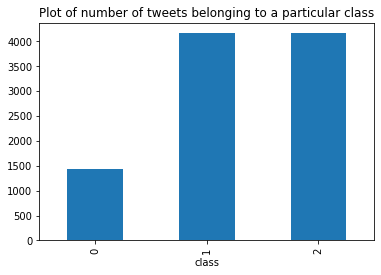

In [51]:
dataset.groupby('class')['id'].nunique().plot(kind='bar',title='Plot of number of tweets belonging to a particular class')

# **Data Cleaning**

In [52]:
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

In [53]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
stop_words= set(stopwords.words('english'))

In [55]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [56]:
def clean_tweet(tweet):
    tweet = re.sub("#", "",tweet) # Removing '#' from hashtags
    tweet = re.sub("[^a-zA-Z#]", " ",tweet) # Removing punctuation and special characters
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',"<URL>", tweet)
    tweet = re.sub('http','',tweet)
    tweet = re.sub(" +", " ", tweet)
    tweet = tweet.lower()
    tweet = word_tokenize(tweet)
    return_tweet=[]
    for word in tweet:
        if word not in stop_words:
            return_tweet.append(word)
    return return_tweet
dataset["tweet"]=dataset["tweet"].apply(clean_tweet)


# **Word2Vec model to get the word embedings.**

In [57]:
model = Word2Vec(dataset["tweet"].values, size=50, window=5, min_count=1, workers=4)

In [58]:
def get_features(tweet):
    features=[]
    for word in tweet:
        features.append(model.wv[word])
    return np.mean(features,0)

In [59]:
dataset["features"]=dataset["tweet"].apply(get_features)

In [60]:
data=[]
for i in dataset["features"].values:
    temp=[]
    for j in i:
        temp.append(j)
    data.append(temp)
data=np.array(data)

In [61]:
from sklearn.preprocessing import label_binarize

Y = label_binarize(dataset["class"].values, classes=[0, 1, 2])
n_classes = Y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

In [62]:
print(X_train)
print(y_train)

[[-0.06306931  0.07168544 -0.09115846 ...  0.05248846 -0.08868144
   0.10382508]
 [-0.07629064  0.08538336 -0.11393562 ...  0.06254011 -0.10252975
   0.12103655]
 [-0.1222057   0.13868204 -0.17287907 ...  0.09316854 -0.1669196
   0.18665284]
 ...
 [-0.16770081  0.18654367 -0.23339637 ...  0.13469216 -0.225134
   0.25416034]
 [-0.10579146  0.11767912 -0.15013085 ...  0.07842886 -0.14333655
   0.16081028]
 [-0.21027526  0.23785895 -0.27906647 ...  0.15470986 -0.2716108
   0.31326446]]
[[0 0 1]
 [0 0 1]
 [0 1 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 0 1]]


# **LOGISTIC REGRESSION MODEL**

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

F1 Score:  0.5286450439527128
Precision Score:  0.6473645137342242
Recall Score:  0.44672131147540983
Accuracy:  0.44672131147540983


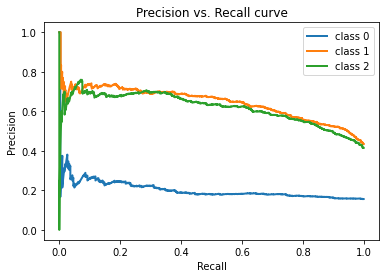

In [64]:
lr_clf = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'))
lr_clf.fit(X_train,y_train)
y_pred = lr_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", lr_clf.score(X_test,y_test))

y_score = lr_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "best")
plt.title("Precision vs. Recall curve")
plt.show()

# ***SVM MODEL***

F1 Score:  0.4797759800871188
Precision Score:  0.6109350237717908
Recall Score:  0.3949795081967213
Accuracy:  0.3949795081967213


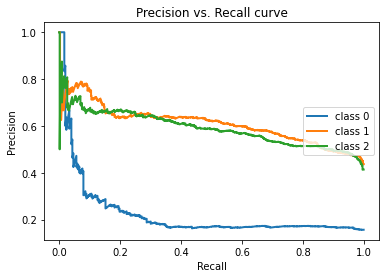

In [65]:
svm_clf = OneVsRestClassifier(svm.SVC(gamma='scale', probability=True))
svm_clf.fit(X_train,y_train)
y_pred = svm_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", svm_clf.score(X_test,y_test))

y_score = svm_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "center right")
plt.title("Precision vs. Recall curve")
plt.show()

## BERT + CNN


### Data Cleaning for BERT

In [66]:
model_class = transformers.AutoModel
tokenizer_class = transformers.AutoTokenizer
pretrained_weights = 'vinai/bertweet-base'

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [67]:
max_seq = 35
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df["tweet"].values
    ]
def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])
def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)
def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [68]:
max = 0
for i in df["tweet"]:
  if len(i) > max:
    max = len(i)
print(max)

31


In [69]:
for i in range(0,len(dataset["tweet"])):
  dataset["tweet"][i] = " ".join(dataset["tweet"][i])

In [70]:
dataset["tweet"]

0       blackman tide whalelookyhere howdydowdy queer ...
1       cb baby white thunduh alsarabsss hes beaner sm...
2       devilgrimz vigxrarts fucking gay blacklisted h...
3       markroundtreejr lmfaoooo hate black people co ...
4             nochillpaz least nigger co rgja cfoit lmfao
                              ...                        
9751        yaya ho cute avi tho rt vivala ari idea sleep
9752    yea n tel new friend friends kno allowed one c...
9753    know say early bird gets worm puts gummy worms...
9754      gone broke wrong heart baby drove redneck crazy
9755    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 9756, dtype: object

In [71]:
indices = tokenize_and_pad_text(dataset, max_seq)

[no,_] = list(indices.shape)

In [72]:


stepSize = 32
X = np.empty([0,max_seq,768])

for i in range(0,no,stepSize):
  if no - i <= stepSize:
    n = no
  else:
    n = i+stepSize
  with torch.no_grad():
    x = bert_model(indices[i:n,:])[0].detach().numpy()
  X = np.vstack([X,x])

In [73]:
label_col = ["class"]
Y = targets_to_tensor(dataset,label_col)

In [74]:
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size=0.2,random_state=42)
x_train = torch.tensor(x_train,dtype=torch.float32)
x_val = torch.tensor(x_val,dtype=torch.float32)

In [75]:
loss_func = nn.CrossEntropyLoss()

In [76]:
class HTSPC_CNN(nn.Module):
    def __init__(self,embed_num,embed_dim,class_num,kernel_num,kernel_sizes,dropout,static):
        super(HTSPC_CNN, self).__init__()
        
        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.emed_layer = nn.Embedding(V, D)
        
        self.conv1 = nn.ModuleList([nn.Conv2d(1,Co,(K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        
        self.lin1 = nn.Linear(len(Ks)* Co, 3)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self,xb):
        if self.static:
            x = Variable(xb)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.conv1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.lin1(x)
        return x

In [77]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    yb = yb.squeeze_()
    # print(model(xb).squeeze_())
    # print(yb)  
    loss = loss_func(model(xb.float()), yb.long())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [78]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)


In [80]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [86]:
bs = 128
epochs = 50
learning_rate = 0.0005

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_val  , y_val  )

embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]

print(class_num)

kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

train_dl, valid_dl = get_data(train_dataset, valid_dataset, bs)
model = HTSPC_CNN(embed_num,embed_dim,class_num,kernel_num,kernel_sizes,dropout,static)

opt = torch.optim.Adam(model.parameters(), lr = learning_rate)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

1
0 0.8279057741165161
1 0.7306693538290555
2 0.6844823780607004
3 0.6534465316866265
4 0.6263836348643068
5 0.6127848273417988
6 0.6086950175097732
7 0.5926958449551316
8 0.5899056733631697
9 0.5795479973808664
10 0.5757885760948306
11 0.5757078889940606
12 0.5692725201122096
13 0.5685549222055029
14 0.5673204074140454
15 0.5603441781685
16 0.5612603250097056
17 0.5620513001426322
18 0.5612004067077011
19 0.5611845108329273
20 0.5609887193460934
21 0.5571098933454419
22 0.5553483357194995
23 0.556860839734312
24 0.5582409676958303
25 0.5536659477186985
26 0.551302975318471
27 0.5639372438680931
28 0.5537377165966346
29 0.5587554847607847
30 0.5565316423040921
31 0.5523059485388584
32 0.5631451137730332
33 0.5579785606900199
34 0.5616248181608857
35 0.5580277120480772
36 0.5524063716169263
37 0.5547493500787704
38 0.5538219682505874
39 0.5528454448356003
40 0.5638354322949394
41 0.5576743727824727
42 0.5619226567080764
43 0.5554016799223228
44 0.5648429491480843
45 0.5595732448530979
4

In [87]:
_,preds = torch.max(model(x_val),1)

In [88]:
print(accuracy_score(preds.detach().numpy(),y_val.detach().numpy()))

0.7607581967213115


In [89]:
f = f1_score(preds.detach().numpy(),y_val.detach().numpy(), average='weighted')
print("F1 Score: ", f)
p = precision_score(preds.detach().numpy(),y_val.detach().numpy(), average='weighted')
print("Precision Score: ", p)
r = recall_score(preds.detach().numpy(),y_val.detach().numpy(), average='micro')
print("Recall Score: ", r)

F1 Score:  0.8102852408757172
Precision Score:  0.8778235174835873
Recall Score:  0.7607581967213115


In [84]:
class HTSPC_LSTM(nn.Module):
  def __init__(self,embed_num,embed_dim,hidden_dim,static):
    super(HTSPC_LSTM,self).__init__()
    
    self.lstm = nn.LSTM(embed_dim,hidden_dim)
    self.static = static
    self.lin1 = nn.Linear(hidden_dim,1)
  
  def forward(self,xb):
    if self.static:
      x = Variable(xb)
    # x = x.unsqueeze(1)
    x, _ = self.lstm(x)
    x = self.lin1(x)
    # print(x.size())
    return x

In [85]:
model = HTSPC_LSTM(embed_num,embed_dim,5,static)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

ValueError: ignored